In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob


(720, 1280, 3)


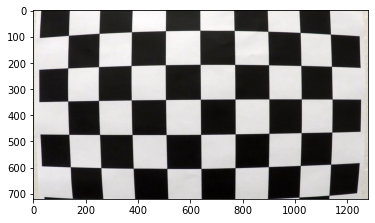

In [3]:
img = mpimg.imread('camera_cal/calibration1.jpg')
image_shape = img.shape
print(image_shape)
plt.imshow(img)

In [4]:
object_points = []
image_points = []
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

fnames = glob.glob("camera_cal/calibration*.jpg")

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret:
        object_points.append(objp)
        image_points.append(corners)
        
ret, camera_matrix, distortion_coeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image_shape[:2],None,None)

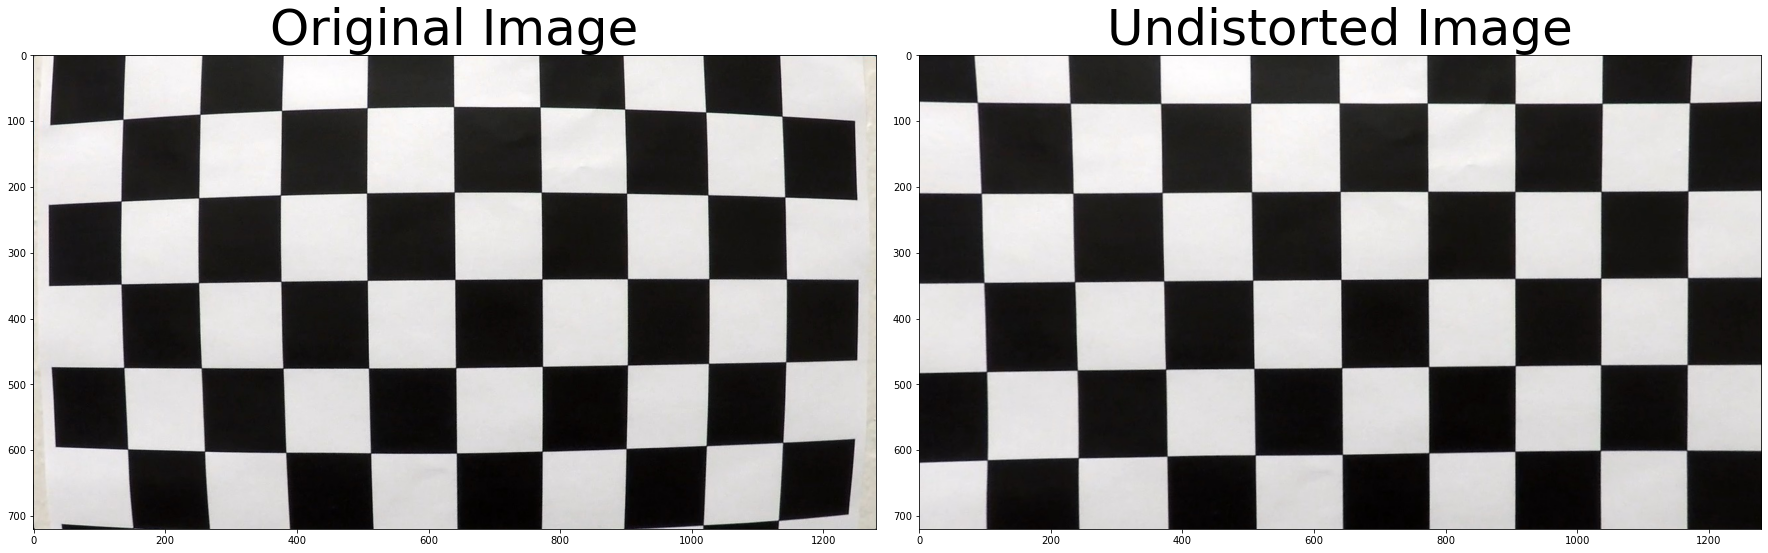

In [5]:
img = mpimg.imread('camera_cal/calibration1.jpg')
undistorted_img = cv2.undistort(img, camera_matrix, distortion_coeffs, None, camera_matrix)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

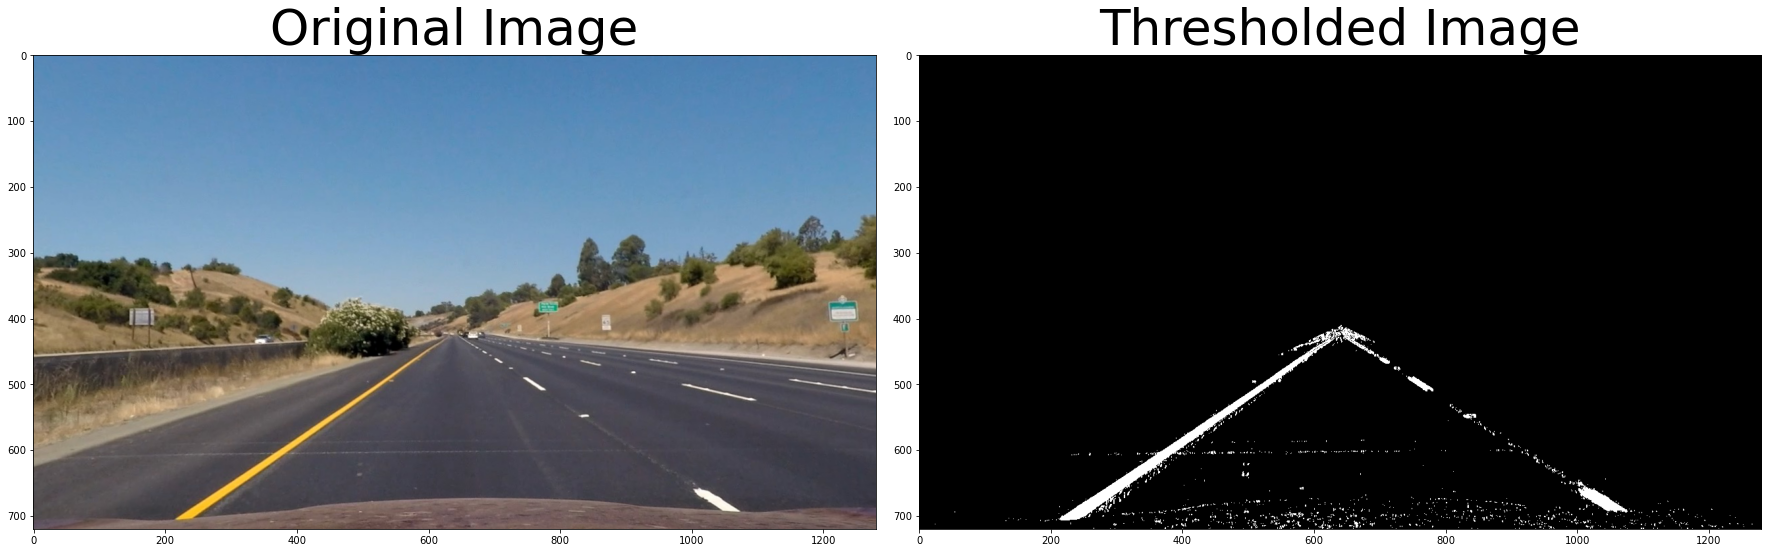

In [85]:
img = mpimg.imread('test_images/straight_lines1.jpg')
img = cv2.undistort(img, camera_matrix, distortion_coeffs, None, camera_matrix)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
height, width = gray.shape
sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
abs_sobel = np.absolute(sobel)
max_value = np.max(abs_sobel)
binary_output = np.uint8(255*abs_sobel/max_value)
threshold_mask = np.zeros_like(binary_output)
threshold_mask[(binary_output >= 10) & (binary_output <= 200)] = 1

sobel_kernel = 5
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
# 3) Take the absolute value of the x and y gradients
abs_sobel_x = np.absolute(sobel_x)
abs_sobel_y = np.absolute(sobel_y)
# 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
direction = np.arctan2(abs_sobel_y,abs_sobel_x)
direction = np.absolute(direction)
# 5) Create a binary mask where direction thresholds are met
dir_mask = np.zeros_like(direction)
dir_mask[(direction >= np.pi/6) & (direction <= np.pi/2)] = 1
#print(dir_mask)

combined_sobel = ((threshold_mask == 1) & (dir_mask == 1))

R = img[:,:,0]
r_thresh = (120, 255)
R_mask = np.zeros_like(R)
R_mask[(R >= r_thresh[0]) & (R <= r_thresh[1])] = 1

combined_mask[(threshold_mask == 1) & (dir_mask == 1)] = 1

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
S = hls[:,:,2]
L = hls[:,:,1]

s_thresh = (100,255)
S_mask = np.zeros_like(S)
S_mask[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1

l_thresh = (120, 255)
L_mask = np.zeros_like(S)
L_mask[(S >= l_thresh[0]) & (S <= l_thresh[1])] = 1
#print(S_mask)

combined = np.zeros_like(S)
combined[((threshold_mask == 1) | (S_mask == 1))] = 1

mask = np.zeros_like(combined)
region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height + 50)], [width-1, height-1]], dtype=np.int32)
cv2.fillPoly(mask, [region_of_interest_vertices], 1)
thresholded = cv2.bitwise_and(combined, mask)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)